# Librerias 📚

In [1]:
import glob
import os
import json
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
import time

# IPNYB
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


2023-05-30 00:35:39.958435: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Obtain files 🗂️

In [2]:
files_MUM = glob.glob('translations/mu-/*.json')
files_MUP = glob.glob('translations/mu+/*.json')

# Building X and y matrices

In [3]:
def reconstruct_matrix(data):
    # Declaration of a three-dimensional numpy matrix with two channels (side 1 and side 2) to give to a CNN.
    # The matrix will be filled with the energy deposited in each sparse coordinate (same coordinates as in the matrix).
    # The first channel is filled with the energy from the hits of the side 1 and the second channel is filled with the energy from hits of the side 2.
    
    for event, event_data in data.items():
        gruid_hits_side_1 = event_data['gruid hits - side 1']
        gruid_hits_side_2 = event_data['gruid hits - side 2']
        gruid_metadata = event_data['gruid metadata']
     
    matrix = np.zeros((gruid_metadata['# of rows (y)'], gruid_metadata['# of columns (x)'], 2))

    # IMPORTANT: Coordinates are inverted in the matrix because of matrix notation in GRUID.
    
    # Side 1
    for timestamp, timestamp_data in gruid_hits_side_1.items():
        for pixel, pixel_data in timestamp_data.items():
            x, y = pixel.split(",")
            matrix[ int(y), int(x), 0 ] = pixel_data['energy deposited']

    # Side 2
    for timestamp, timestamp_data in gruid_hits_side_2.items():
        for pixel, pixel_data in timestamp_data.items():
            x, y = pixel.split(",")
            matrix[ int(y), int(x), 1 ] = pixel_data['energy deposited']
        
    return matrix

muon_labels = np.ones(len(files_MUM))
antimuon_labels = np.zeros(len(files_MUP))
y = np.concatenate((muon_labels, antimuon_labels))

X = []
for file in files_MUM:
        with open(file) as f:
                data = json.load(f)
        X.append(reconstruct_matrix(data))
        
for file in files_MUP:
        with open(file) as f:
                data = json.load(f)
        X.append(reconstruct_matrix(data))
X = np.array(X)

## Saving Matrices to files

In [ ]:
# Save matrices to file
np.save('matrices/X.npy', X)
np.save('matrices/y.npy', y)

# Code 💻

## Loading saved matrices 

In [2]:
# Load matrices from previously generated files
X = np.load('matrices/X.npy')
y = np.load('matrices/y.npy')

## Reviewing Shapes

In [3]:
X.shape, y.shape

((10167, 7, 5, 2), (10167,))

## Splitting the data

In [4]:
# Splitting the data into training and testing sets
# We will use 80% of the data for training and 20% of the data for testing.
# We will use the function train_test_split from sklearn.model_selection to split the data.
# We will use the parameter stratify to split the data in a stratified way.
# We will split the training data into training and validation sets.
# We will use 80% of the training data for training and 20% of the training data for validation.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((6506, 7, 5, 2), (1627, 7, 5, 2), (2034, 7, 5, 2), (6506,), (1627,), (2034,))

In [5]:
# Show target vector (1 = muon, 0 = antimuon)
print(y_train)

[1. 0. 0. ... 0. 1. 1.]


## Reshaping with the keras.smart_resize 32x32 CNN approach

### Reshape

In [6]:
# Making sure that the data is in the correct format for the CNN
# We will use the function reshape from numpy to reshape the data.
# We will reshape the data to have 4 dimensions. Parameter 1 will be the number of events, 2 and 3 will be the dimensions of the matrix and 4 will be the number of channels.
# Images are not square, so we will proportionally resize the images to be square.

# Dimensions to resize the images to
ROWS = 32
COLS = 32

X_train = np.array([keras.preprocessing.image.smart_resize(image, (ROWS, COLS)) for image in X_train])
X_val = np.array([keras.preprocessing.image.smart_resize(image, (ROWS, COLS)) for image in X_val])
X_test = np.array([keras.preprocessing.image.smart_resize(image, (ROWS, COLS)) for image in X_test])

# Normalizing the data
# We will use the function normalize from keras.utils to normalize the data.
# We will normalize the data by dividing the data by the maximum value of the data.
X_train = keras.utils.normalize(X_train, axis=1)
X_val = keras.utils.normalize(X_val, axis=1)
X_test = keras.utils.normalize(X_test, axis=1)

# Reshaping the target data to have 2 dimensions (one-hot encoding)
y_train = keras.utils.to_categorical(y_train, 2)
y_val = keras.utils.to_categorical(y_val, 2)
y_test = keras.utils.to_categorical(y_test, 2)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((6506, 32, 32, 2),
 (1627, 32, 32, 2),
 (2034, 32, 32, 2),
 (6506, 2),
 (1627, 2),
 (2034, 2))

In [7]:
# Show target vector ([0,1] = muon, [1,0] = antimuon)
y_train

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

### Plot

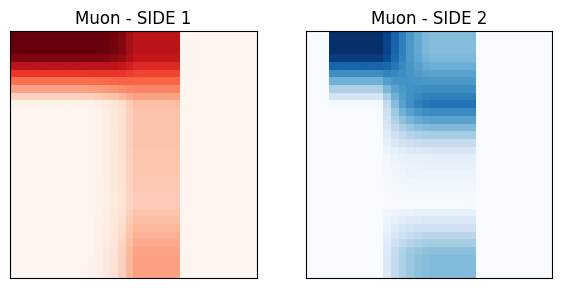

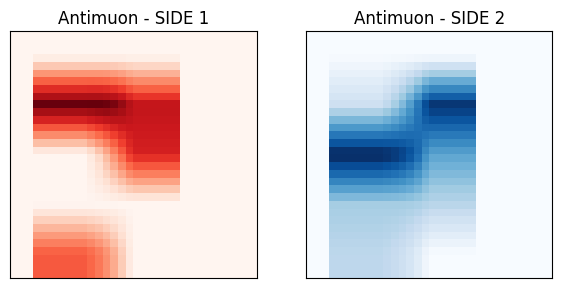

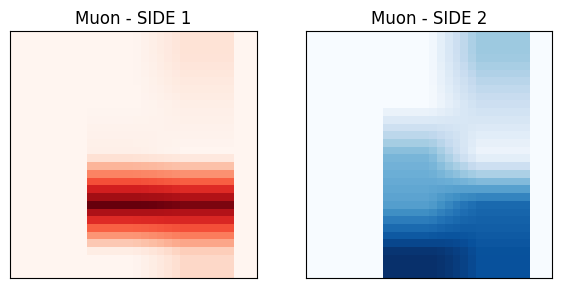

In [8]:
# Plotting a muon event
# We will plot a muon event from the training set.
# We will use the function imshow from matplotlib.pyplot to plot the event.
# We will use the parameter cmap to plot the two channels of the event with different colors.
# Plotting the two channels of the event with different colors with shared axis.
# Plot 3 random events from the training set.

random_events = np.random.randint(0, X_train.shape[0], 3)

for i in random_events:
        plt.figure(figsize=(7,7))
        plt.subplot(1,2,1)
        plt.imshow(X_train[i,:,:,0], cmap='Reds')
        plt.title('Muon - SIDE 1' if y_train[i][0] == 0 else 'Antimuon - SIDE 1')
        plt.xticks([])
        plt.yticks([])
        plt.subplot(1,2,2, sharex=plt.gca(), sharey=plt.gca())
        plt.imshow(X_train[i,:,:,1], cmap='Blues')
        plt.title('Muon - SIDE 2' if y_train[i][0] == 0 else 'Antimuon - SIDE 2')
        # Show tick labels on both sides
        plt.tick_params('x', labelbottom=True, labeltop=True)
        plt.tick_params('y', labelleft=True, labelright=True)
        
plt.show()

### CNN 1

In [9]:
# CNN
# We will use a CNN to classify the events.
# The input of the CNN will be a matrix with two channels (side 1 and side 2) with the energy deposited in each sparse coordinate.
# The output of the CNN will be a vector with two elements (one for each class).
# The CNN will have two convolutional layers, two max pooling layers and two dense layers.
# The first convolutional layer will have 32 filters and the second convolutional layer will have 64 filters.
# The first dense layer will have 64 neurons and the second dense layer will have 2 neurons (one for each class).
# The activation function of the first dense layer will be ReLU and the activation function of the second dense layer will be softmax.
# The loss function will be categorical crossentropy and the optimizer will be Adam.
# The metrics will be f1-score , precision, recall, AUC and accuracy.

def f1_score(precision, recall):
        return 2 * (precision * recall) / (precision + recall)

model_cpcp = keras.Sequential([
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(2, activation='softmax')
        ])

# Compile the model and build F1 score metric
model_cpcp.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              #metrics=[keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(), keras.metrics.AUC(curve='ROC'), 'accuracy', f1_score])

model_cpcp.summary()

# Time the training
start = time.time()
history_cpcp = model_cpcp.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))
end = time.time()
print('Training time:', end - start)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 64)                1

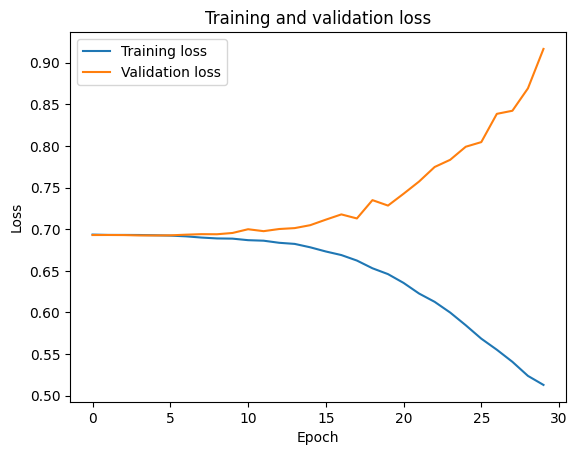

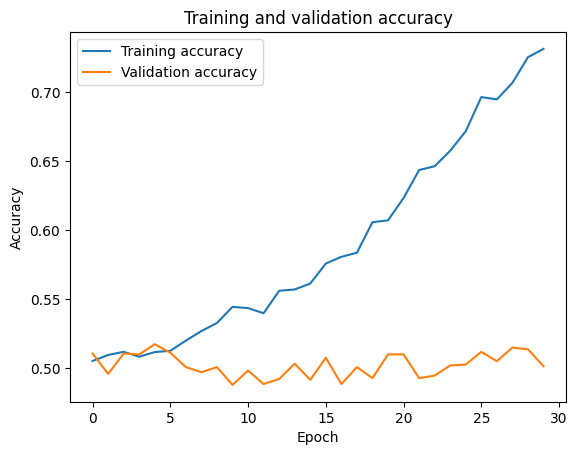

In [11]:
# Plotting the training and validation loss
# We will use the function plot from matplotlib.pyplot to plot the training and validation loss.
# We will use the function title from matplotlib.pyplot to add a title to the plot.

plt.plot(history_cpcp.history['loss'], label='Training loss')
plt.plot(history_cpcp.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
# We will use the function plot from matplotlib.pyplot to plot the training and validation accuracy.
# We will use the function title from matplotlib.pyplot to add a title to the plot.

plt.plot(history_cpcp.history['accuracy'], label='Training accuracy')
plt.plot(history_cpcp.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### CNN 2

In [12]:
# CNN
# We will use a CNN to classify the events.
# The input of the CNN will be a matrix with two channels (side 1 and side 2) with the energy deposited in each sparse coordinate.
# The output of the CNN will be a vector with two elements (one for each class).
# The CNN will have two convolutional layers, two max pooling layers and two dense layers.
# The first convolutional layer will have 32 filters, a kernel size of 3x3, a stride of 1x1 and a ReLU activation function.
# The first max pooling layer will have a pool size of 2x2 and a stride of 2x2.
# The second convolutional layer will have 64 filters, a kernel size of 3x3, a stride of 1x1 and a ReLU activation function.
# The second max pooling layer will have a pool size of 2x2 and a stride of 2x2.
# The first dense layer will have 128 neurons and a ReLU activation function.
# The second dense layer will have 2 neurons and a softmax activation function.
# We will use the Adam optimizer with a learning rate of 0.001.
# We will use the categorical crossentropy loss function.
# We will use the accuracy metric.
# We will train the CNN for 10 epochs with a batch size of 32.

# Create the CNN

def f1_score(precision, recall):
        return 2 * (precision * recall) / (precision + recall)

model = keras.models.Sequential([
        keras.layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
        keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        keras.layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(2, activation='softmax')
])

# Compile the CNN
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
              #metrics=[keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(), keras.metrics.AUC(curve='ROC'), 'accuracy', f1_score])

model.summary()

# Time the training
start = time.time()
history = model.fit(X_train, y_train, epochs=70, validation_data=(X_val, y_val))
end = time.time()
print('Training time:', end - start)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        608       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 2304)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

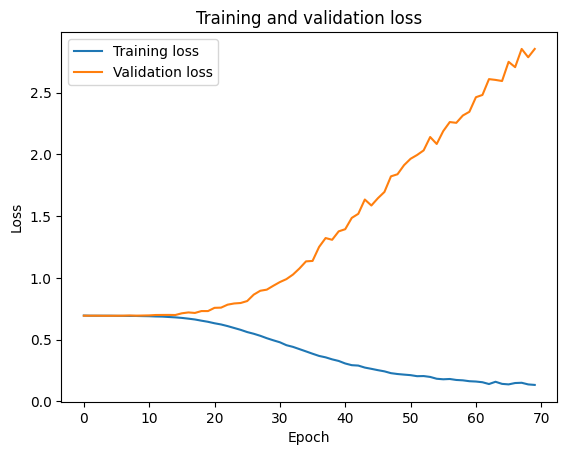

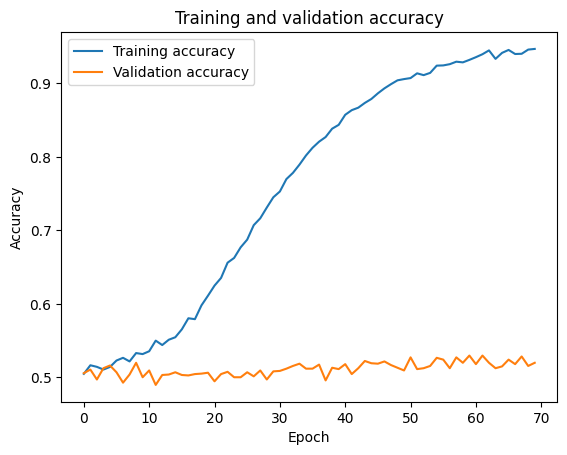

In [13]:
# Plotting the training and validation loss
# We will use the function plot from matplotlib.pyplot to plot the training and validation loss.
# We will use the function title from matplotlib.pyplot to add a title to the plot.

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
# We will use the function plot from matplotlib.pyplot to plot the training and validation accuracy.
# We will use the function title from matplotlib.pyplot to add a title to the plot.

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Feed-Forward Approach

### Reshape

In [6]:
# Normalizing the data
# We will use the function normalize from keras.utils to normalize the data.
# We will normalize the data by dividing the data by the maximum value of the data.
X_train = keras.utils.normalize(X_train, axis=1)
X_val = keras.utils.normalize(X_val, axis=1)
X_test = keras.utils.normalize(X_test, axis=1)

# Reshape the data for a fit forward neural networ
# Reshape the y data to be a column one-hot encoded vector.
y_train = keras.utils.to_categorical(y_train, 2)
y_val = keras.utils.to_categorical(y_val, 2)
y_test = keras.utils.to_categorical(y_test, 2)

### FFNN

In [9]:
# Trying with a different approach
# We will use a Feed-forward Neural Network to classify the events.
# The input of the Fit-forward Neural Network will be a matrix with two channels (side 1 and side 2) with the energy deposited in each sparse coordinate.
# The output of the Fit-forward Neural Network will be a vector with two elements (one for each class).
# The Fit-forward Neural Network will have two dense layers.
# The first dense layer will have 64 neurons and the second dense layer will have 2 neurons (one for each class).
# The activation function of the first dense layer will be ReLU and the activation function of the second dense layer will be softmax.
# The loss function will be categorical crossentropy and the optimizer will be Adam.
# The metrics will be f1-score , precision, recall, AUC and accuracy.

def f1_score(precision, recall):
        return 2 * (precision * recall) / (precision + recall)

model = keras.Sequential([
        keras.layers.Flatten(input_shape=(7, 5, 2)),
        keras.layers.Dense(2, activation='softmax')
        ])

# Compile the model and build F1 score metric
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
              metrics=['accuracy'])
              #metrics=[keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(), keras.metrics.AUC(curve='ROC'), 'accuracy', f1_score])

model.summary()

# Time the training
start = time.time()
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))
end = time.time()
print('Training time:', end - start)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 70)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 142       
                                                                 
Total params: 142
Trainable params: 142
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
204/204 [==============================] - 1s 2ms/step - loss: 0.7020 - accuracy: 0.5074 - val_loss: 0.7002 - val_accuracy: 0.4923
Epoch 2/30
204/204 [==============================] - 0s 1ms/step - loss: 0.6968 - accuracy: 0.5074 - val_loss: 0.6980 - val_accuracy: 0.4911
Epoch 3/30
204/204 [==============================] - 0s 2ms/step - loss: 0.6947 - accuracy: 0.5100 - val_loss: 0.6972 - val_accuracy: 0.4862
Epoch 4/30
204/204 [======

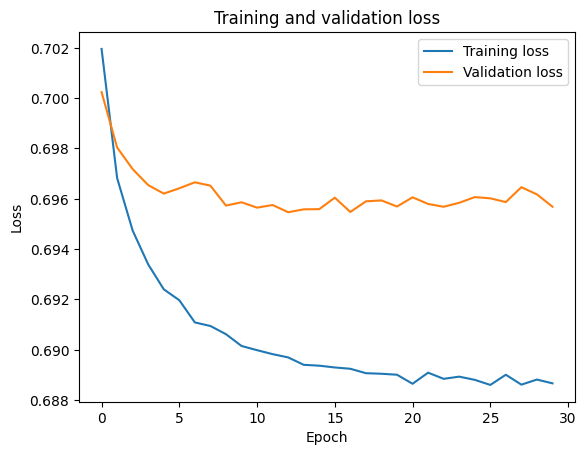

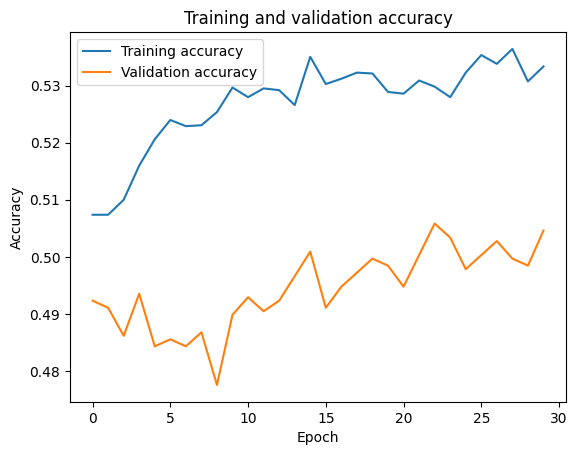

In [10]:
# Plotting the training and validation loss
# We will use the function plot from matplotlib.pyplot to plot the training and validation loss.
# We will use the function title from matplotlib.pyplot to add a title to the plot.

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
# We will use the function plot from matplotlib.pyplot to plot the training and validation accuracy.
# We will use the function title from matplotlib.pyplot to add a title to the plot.

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Reshaping with np.pad with zeros for a 7x7 CNN aproach (not working because of filter/layer dimension issues)

### Reshape

In [6]:
# We want to bring the dimension from each matrix from 7,5,2 to 7,7,2.
# We will use numpy.pad to pad the matrices with zeros.
# We will pad the matrices with zeros in the third dimension (columns) and calculate the necessary padding for each matrix.

X_train = np.pad(X_train, ((0,0),(0,0),(0, X_train.shape[1]-X_train.shape[2]), (0,0)), mode='constant')
X_val = np.pad(X_val, ((0,0),(0,0),(0, X_val.shape[1]-X_val.shape[2]), (0,0)), mode='constant')
X_test = np.pad(X_test, ((0,0),(0,0),(0, X_test.shape[1]-X_test.shape[2]), (0,0)), mode='constant')

# Normalizing the data
# We will use the function normalize from keras.utils to normalize the data.
# We will normalize the data by dividing the data by the maximum value of the data.
X_train = keras.utils.normalize(X_train, axis=1)
X_val = keras.utils.normalize(X_val, axis=1)
X_test = keras.utils.normalize(X_test, axis=1)

# Reshape the y data to be a column one-hot encoded vector.
y_train = keras.utils.to_categorical(y_train, 2)
y_val = keras.utils.to_categorical(y_val, 2)
y_test = keras.utils.to_categorical(y_test, 2)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((6506, 7, 7, 2),
 (1627, 7, 7, 2),
 (2034, 7, 7, 2),
 (6506, 2),
 (1627, 2),
 (2034, 2))

In [7]:
# Show target vector ([0,1] = muon, [1,0] = antimuon)
y_train

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

### Plot events

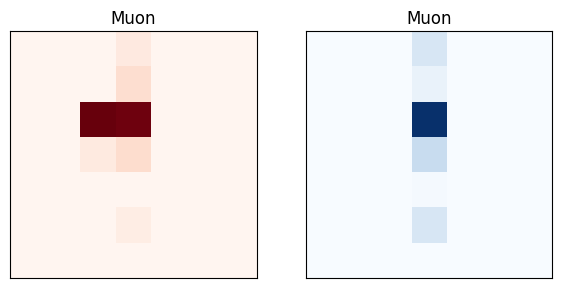

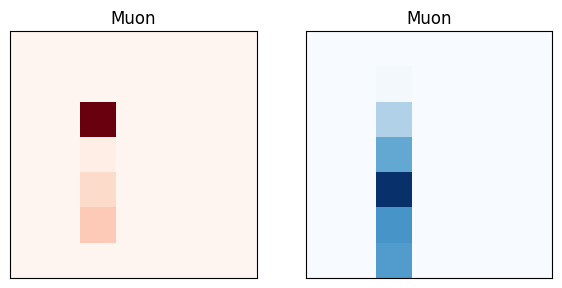

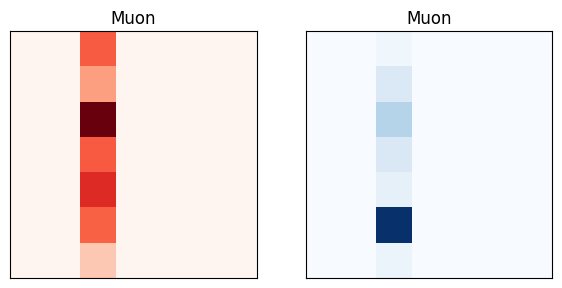

In [8]:
# Plotting a muon event
# We will plot a muon event from the training set.
# We will use the function imshow from matplotlib.pyplot to plot the event.
# We will use the parameter cmap to plot the two channels of the event with different colors.
# Plotting the two channels of the event with different colors with shared axis.
# Plot 3 random events from the training set.

random_events = np.random.randint(0, X_train.shape[0], 3)

for i in random_events:
        plt.figure(figsize=(7,7))
        plt.subplot(1,2,1)
        plt.imshow(X_train[i,:,:,0], cmap='Reds')
        plt.title('Muon' if y_train[i][0] == 0 else 'Antimuon')
        plt.xticks([])
        plt.yticks([])
        plt.subplot(1,2,2, sharex=plt.gca(), sharey=plt.gca())
        plt.imshow(X_train[i,:,:,1], cmap='Blues')
        plt.title('Muon' if y_train[i][0] == 0 else 'Antimuon')
        # Show tick labels on both sides
        plt.tick_params('x', labelbottom=True, labeltop=True)
        plt.tick_params('y', labelleft=True, labelright=True)
        
plt.show()
        

In [9]:
# CNN
# We will use a CNN to classify the events.
# The input of the CNN will be a matrix with two channels (side 1 and side 2) with the energy deposited in each sparse coordinate.
# The output of the CNN will be a vector with two elements (one for each class).
# The CNN will have two convolutional layers, two max pooling layers and two dense layers.
# The first convolutional layer will have 32 filters of size 3x3.
# The second convolutional layer will have 64 filters of size 3x3.
# The first max pooling layer will have a pool size of 2x2.
# The second max pooling layer will have a pool size of 2x2.
# The first dense layer will have 128 neurons.
# The second dense layer will have 2 neurons.


# Create the CNN
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(7, 7, 2)))
model.add(keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(2, activation='softmax'))

# Compile the CNN
model.compile(loss='categorical_crossentropy', optimizer=keras.Adam(lr=0.0001), metrics=['accuracy'])

# Show the model summary
model.summary()

# Time the training
start = time.time()
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))
end = time.time()
print('Training time:', end - start)

# Evaluate the CNN
#score = model.evaluate(X_test, y_test, verbose=0)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

# Predict the classes of the test set
#y_pred = model.predict(X_test)

ValueError: One of the dimensions in the output is <= 0 due to downsampling in conv2d_2. Consider increasing the input size. Received input shape [None, 1, 1, 64] which would produce output shape with a zero or negative value in a dimension.

In [ ]:
# Plotting the training and validation loss
# We will use the function plot from matplotlib.pyplot to plot the training and validation loss.
# We will use the function title from matplotlib.pyplot to add a title to the plot.

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
# We will use the function plot from matplotlib.pyplot to plot the training and validation accuracy.
# We will use the function title from matplotlib.pyplot to add a title to the plot.

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()